In [44]:
#Problemes:
reincorporer numchannels, numarfcn

What I want:
    #Prepare final dataset of results
bts_analysis=pd.DataFrame(columns=['cellid','first_time','last_time','nb_obs','la_std','lng_std','average_rx_level',\
                                   'constant_parameters','lac_present','arfcn_present'])

SyntaxError: invalid syntax (<ipython-input-44-81b88b97e163>, line 2)

In [46]:
output_filename="summary_db_json.js"

### 0. Import libraries

In [47]:
import sys, os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy
from math import *
from itertools import chain
import datetime

### 1. Import Data

In [48]:
db=json.load(open('db_json'))
db = pd.DataFrame.from_dict(db, orient='columns')
db.reset_index(level=0, inplace=True)

print db.columns
columns_sub_set=[ 'bsic', 'cellid','arfcn','lac','cellStatus', 
                'latabs', 'lngabs', 'mcc', 'mnc',  'rxlev','surv_time','neigh']

db_final=db[columns_sub_set]
print " \nColumns of the database after selection: \n \n %s " %str(db_final.columns) 

#Convert what's needed to numeric
col_num=[i for i in columns_sub_set if i not in ('cellstatus','surv_time','neigh')]
db_final[col_num] = db_final[col_num].apply(pd.to_numeric, errors='coerce')

#Drop missing values
db_final=db_final[db_final['cellid'].notna() & db_final["latabs"].notna() & \
                  db_final["surv_time"].notna() & db_final["cellid"]!=0]
db_final=db_final.reset_index()

#Manage dates
db_final.surv_time=db_final.surv_time.str.split('+').str[0].str.replace('"','')
db_final.surv_time="20"+db_final.surv_time
db_final['date'] = pd.to_datetime(db_final['surv_time'], format='%Y/%m/%d,%H:%M:%S')

print db_final[:5]

Index([     u'index',      u'alpha',      u'arfcn',    u'bscvmax',
             u'bsic', u'cellStatus',     u'cellid',   u'channels',
          u'ctrlack',     u'drxmax',    u'gp_time',        u'lac',
           u'latabs',     u'lngabs',        u'mcc',        u'mnc',
              u'nco',      u'neigh',        u'nom',        u'pat',
            u'pbcch',   u'pcmeasch',        u'rac',      u'rxlev',
             u'spgc',  u'surv_time',      u't3168',      u't3192'],
      dtype='object')
 
Columns of the database after selection: 
 
 Index([u'bsic', u'cellid', u'arfcn', u'lac', u'cellStatus', u'latabs',
       u'lngabs', u'mcc', u'mnc', u'rxlev', u'surv_time', u'neigh'],
      dtype='object') 
   index  bsic  cellid  arfcn    lac  cellStatus     latabs    lngabs  mcc  \
0      5    43   57179      5  10300         NaN  47.968393 -1.400657  208   
1      6    46   22571    987    284         NaN  47.968398 -1.400670  208   
2      7    11   49645     81   6001         NaN  47.968393 -1.4

In [49]:
#Look at some first descriptive statistics
print "(Nb obs, Nb Variables):%s \n" %str(db_final.shape)
print "Unique Antennas: %s \n" %str(len(db_final['cellid'].unique()))
print "Average number of obs by antennas: %s \n" %str(db_final['cellid'].value_counts().mean())
db_final['nb']=db_final['cellid'].groupby(db_final['cellid']).transform('value_counts')
var=db_final[db_final['nb']>1]['cellid'].nunique()
var2=db_final[db_final['nb']>2]['cellid'].nunique()

print "Antennas with more than one observation: %s \n" %str(var)
print "Antennas with more than two observations: %s \n" %str(var2)

(Nb obs, Nb Variables):(17860, 14) 

Unique Antennas: 387 

Average number of obs by antennas: 46.14987080103359 

Antennas with more than one observation: 316 

Antennas with more than two observations: 260 



### 2. Individual Cell Level Descriptive Data

What's needed: first date, last date, number of obs/days observed, single parameters, if parameters changed over time, if it's new

And comparison with its neighbors

In [50]:
############Check first and last date seen as well as number of obs in one line ###########

#https://stackoverflow.com/questions/23178129/getting-min-and-max-dates-from-a-pandas-dataframe
temp=db_final[['surv_time']].groupby(db_final['cellid']).agg(['count','min','max'])\
.rename(columns={'count':'nb_obs','min':'first_time','max':'last_time'})

#Drop multiindex and reset index to keep cellid
temp.columns=temp.columns.droplevel(0)
temp=temp.reset_index()

#Create bts_analysis
bts_analysis=temp

############Check if changes of parameters that shouldn't change############
constant_parameters=[ 'bsic','arfcn','lac','cellStatus', 'mcc', 'mnc'] #numarfcn, numchannels 

def constant_test(x):
    test=(max(x[1],x[2],x[3],x[4],x[5],x[6])==1)
    return test

temp=db_final[constant_parameters]
temp=temp.groupby(db_final['cellid']).nunique().reset_index().rename(columns={'bsic':'nb_bsic','arfcn':'nb_arfcn',\
                                                                              'lac':'nb_lac','cellStatus':'nb_cellstatus',\
                                                                             'mcc':'nb_mcc','mnc':'nb_mnc'})
temp['constant_parameters']=temp.apply(constant_test,axis=1)

#Merge
bts_analysis = pd.merge(bts_analysis,temp,on='cellid')

############ Average Latitude/Lontitude############
temp=db_final[['latabs','lngabs']].groupby(db_final['cellid']).agg(['std'])
temp.columns=temp.columns.droplevel(0)

def movement_test(x):
    test=(max(x[0],x[1]))
    return test

temp['std_max']=temp.apply(movement_test,axis=1)
temp['constant_location']= temp['std_max']<1

temp=temp.reset_index()

#Merge
bts_analysis = pd.merge(bts_analysis,temp[['constant_location','cellid']],on='cellid')

##########"Rxlevel##########""""""
temp=db_final['rxlev'].groupby(db_final['cellid']).agg(['mean']).reset_index()
temp=temp.rename(columns={'mean':'average_rx_level'})

#Merge
bts_analysis = pd.merge(bts_analysis,temp,on='cellid')

######"Check Results#########
print bts_analysis[:5]

   cellid  nb_obs           first_time            last_time  nb_bsic  \
0     869       2  2017/12/29,16:10:53  2017/12/29,16:13:40        1   
1     871       3  2017/12/29,16:52:42  2017/12/29,17:02:25        1   
2    1125       1  2017/12/29,17:04:47  2017/12/29,17:04:47        1   
3    1567       6  2017/12/23,16:24:35  2017/12/29,13:24:09        1   
4    2041       4  2017/12/30,09:09:32  2018/01/20,10:27:04        1   

   nb_arfcn  nb_lac  nb_cellstatus  nb_mcc  nb_mnc  constant_parameters  \
0         1       1              0       1       1                 True   
1         1       1              0       1       1                 True   
2         1       1              0       1       1                 True   
3         1       1              0       1       1                 True   
4         1       1              0       1       1                 True   

   constant_location  average_rx_level  
0               True       -100.000000  
1               True        -85.00

### 3. Neighbors' comparison

Rules:
- Different LAC than neighbors
- Weird LAC/MNC
- Neighbor advertisement

In [51]:
#Neighbors advertising : here a lot of empty list? Why is it?
print "\nNeighbor Advertising Test\n"

def nb_neighb(x):
    if x.keys()!=[]:
        return max(int(i) for i in x.keys())
    else:
        return 0
    
db_final['neigh'].apply(nb_neighb)
print "Done"



Neighbor Advertising Test

Done


### 4. Finding neigbored BTS: can use a buffer around a point and test for other points inclusion, can use n*n distance matrix

https://gis.stackexchange.com/questions/192362/check-if-point-is-within-radius-of-another-point-with-shapely

Using point in polygons?
https://strbeamhacker.com/2010/03/23/python-point-in-polygon-shapely/
    
For each point, simply build a list of neighbor, actualize it from time to time. And then use it to compute local stats.
Another way would be to predefine areas, and include points in it. Then compute summary statistics of areas to which
a given point bleongs.

#### 4.1 Get list of closest BTS

In [52]:
#Haversine distance
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    #print [lon1, lat1, lon2, lat2]
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


#Get unique Cellid and average location
list_bts=db_final[['cellid','latabs','lngabs']].groupby(db_final['cellid']).agg('mean').drop_duplicates()

#List of Coordinates
list_coord=[]
for row in list_bts.iterrows():
    index, data = row
    list_coord.append(data.tolist())

#Get the closest BTS 
dict_closest={}
for j in list_coord:
    dict_closest[j[0]]=[i[0] for i in list_coord \
                        if ( haversine(j[2],j[1],i[2],i[1])<1 \
                       and j[0]!=i[0] )]


#Now compute the group level statistics
print dict_closest

{60967.0: [2099.0, 8055.0, 27927.0, 27929.0, 28129.0, 34419.0, 38811.0, 38977.0, 40437.0], 2063.0: [2041.0, 2065.0, 2353.0, 3533.0, 3589.0, 6451.0, 6459.0, 6491.0, 9321.0, 13529.0, 13589.0, 14891.0, 14893.0, 15337.0, 17729.0, 18303.0, 20025.0, 20099.0, 20553.0, 20555.0, 20561.0, 20565.0, 20567.0, 20581.0, 21503.0, 21505.0, 22043.0, 22067.0, 22383.0, 22843.0, 23529.0, 23533.0, 23571.0, 23581.0, 23589.0, 27403.0, 27405.0, 27427.0, 27455.0, 27487.0, 27495.0, 38819.0, 38941.0, 38981.0, 39123.0, 45327.0, 52139.0, 52397.0, 52399.0, 53209.0, 53211.0, 55689.0, 55691.0, 55707.0, 55709.0, 55715.0, 55725.0, 56441.0, 56585.0], 2065.0: [2041.0, 2063.0, 2353.0, 3533.0, 3589.0, 6451.0, 6459.0, 6491.0, 9321.0, 13529.0, 13589.0, 14891.0, 14893.0, 15337.0, 17729.0, 18303.0, 20025.0, 20099.0, 20553.0, 20555.0, 20561.0, 20565.0, 20567.0, 20581.0, 21503.0, 21505.0, 22043.0, 22067.0, 22383.0, 22843.0, 23529.0, 23533.0, 23571.0, 23581.0, 23589.0, 27403.0, 27405.0, 27427.0, 27455.0, 27487.0, 27495.0, 38819.0,

#### 4.2 Neighbor based detection implementation

1. Unique LAC
2. Cell ID not advertised somewhere else

Rmq: For the time being, no duplicates is being done, because too relou to do on a dictionnary


In [53]:
#Transform dict into pd 
columns=['cellid','bts_closest']
db_closest=pd.DataFrame(columns=columns)
db_closest_results=pd.DataFrame(columns=['cellid','lac_present','arfcn_present'])

#Populate it
for key,values in dict_closest.items():
    db_closest=db_closest.append({'cellid':key,'bts_closest':values},ignore_index=True)

print db_closest[:5]

    cellid                                        bts_closest
0  60967.0  [2099.0, 8055.0, 27927.0, 27929.0, 28129.0, 34...
1   2063.0  [2041.0, 2065.0, 2353.0, 3533.0, 3589.0, 6451....
2   2065.0  [2041.0, 2063.0, 2353.0, 3533.0, 3589.0, 6451....
3  20507.0                                                 []
4  38941.0  [2041.0, 2063.0, 2065.0, 2353.0, 3533.0, 3589....


In [54]:
#Define functions to apply to each row
#ref:https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/#loc-selection
db_closest_results=pd.DataFrame(columns=['cellid','lac_present','arfcn_present'])

for i in db_closest['cellid'].unique():
        #Get cellid arfcn and lac: have to hope for unique parameters...Or if not, return an error and warn the user
        parameters=db_final[['cellid','arfcn','lac']][db_final['cellid']==i].drop_duplicates()
        if parameters.shape[0]==1:
            #print parameters,'\n',db_closest['bts_closest'][db_closest['cellid']==i].item()
            
            #DF with closest advertised arfcns and lac
            subset=db_final[['cellid','neigh','lac']].\
                loc[db_final['cellid'].\
                isin(db_closest['bts_closest'][db_closest['cellid']==i].item())]
                
            #print subset
            nb_neighb=subset['cellid'].nunique()
            #Get unique arfcns and lac and then compare with cellid values
            lac_present=(parameters['lac'].item() in subset['lac'].unique())
            arfcns_advertised=set(chain(*[j for j in subset['neigh'].apply(lambda x: x.values())]))
            arfcn_present=(parameters['arfcn'].item() in arfcns_advertised)
            db_closest_results=db_closest_results.append({'cellid':i,'nb_neighb':nb_neighb,'lac_present':lac_present,'arfcn_present':arfcn_present,'neighb_issue':"None"},ignore_index=True)

        else:
            db_closest_results=db_closest_results.append({'cellid':i,'neighb_issue':"Cellid duplicates, not treated"},ignore_index=True)

            
print db_closest_results[:5]

    cellid lac_present arfcn_present  nb_neighb neighb_issue
0  60967.0        True         False        9.0         None
1   2063.0        True          True       59.0         None
2   2065.0        True          True       59.0         None
3  20507.0       False         False        0.0         None
4  38941.0        True         False       66.0         None


### 5. Merge Database and get results

In [55]:
#Merge both datasets
bts_analysis=pd.merge(bts_analysis, db_closest_results, on='cellid')
print bts_analysis.shape

#Add initial values
bts_analysis=pd.merge(bts_analysis, db_final[['lac','mcc','mnc','cellid']].drop_duplicates('cellid'), on='cellid')

#Reorder columns
bts_analysis=bts_analysis[['cellid','lac','mcc','mnc','first_time','last_time','constant_parameters','constant_location',\
                           'lac_present','arfcn_present','nb_neighb','neighb_issue','nb_bsic','nb_arfcn',\
                           'nb_lac','nb_cellstatus','nb_mcc','nb_mnc']]
print bts_analysis[:5]

def test_date_json(o):
    if isinstance(o, datetime.datetime):
        return o.__str__()

with open(output_filename,"w") as f:
    f.write("var sum =")
    
with open(output_filename,"a+") as f:
    print "Writing JSON SUmmary database into %s"%(output_filename)
    json.dump(bts_analysis.to_dict(orient='records'),f,default=test_date_json,sort_keys=True)



(387, 17)
  cellid    lac  mcc  mnc           first_time            last_time  \
0    869   6404  208    1  2017/12/29,16:10:53  2017/12/29,16:13:40   
1    871   6404  208    1  2017/12/29,16:52:42  2017/12/29,17:02:25   
2   1125   6403  208    1  2017/12/29,17:04:47  2017/12/29,17:04:47   
3   1567  10300  208    1  2017/12/23,16:24:35  2017/12/29,13:24:09   
4   2041    418  208   20  2017/12/30,09:09:32  2018/01/20,10:27:04   

   constant_parameters  constant_location lac_present arfcn_present  \
0                 True               True        True         False   
1                 True               True       False         False   
2                 True              False        True         False   
3                 True               True        True         False   
4                 True               True        True          True   

   nb_neighb neighb_issue  nb_bsic  nb_arfcn  nb_lac  nb_cellstatus  nb_mcc  \
0        4.0         None        1         1       1     

In [ ]:
#Get cellid arfcn and lac: have to hope for unique parameters...Or if not, return an error and warn the user
parameters=db_final[['cellid','arfcn','lac']][db_final['cellid']==2063].drop_duplicates()
print parameters, "\n"

#DF with closest advertised arfcns and lac
subset=db_final[['cellid','neigh','lac']].\
    loc[db_final['cellid'].\
    isin(db_closest['bts_closest'][db_closest['cellid']==2063].item())]

#Get unique arfcns and lac and then compare with cellid values
lac_present=parameters['lac'].item() in subset['lac'].unique()
print lac_present

arfcns_advertised=set(chain(*[i for i in subset['neigh'].apply(lambda x: x.values())]))
arfcn_present=parameters['lac'].item() in arfcns_advertised
print arfcn_present

In [115]:
max(db_final[['cellid','neigh']].\
loc[db_final['cellid'].\
isin(db_closest['bts_closest'][db_closest['cellid']==60967].item())]\
['neigh'].apply(lambda x: 60967 in x.values()))

False

In [114]:
#retrieve the advertised cells of closest cells 
test=db_final[['cellid','neigh']].\
loc[db_final['cellid'].\
isin(db_closest['bts_closest'][db_closest['cellid']==60967].item())]

#Test for the presence of cellid in advertised cells
max(test2['neigh'].apply(lambda x: 60967 in x.values()))


      cellid                                              neigh
999    27929  {u'11': 598, u'10': 597, u'13': 600, u'12': 59...
1010   27929  {u'11': 598, u'10': 597, u'13': 600, u'12': 59...
1011   34419         {u'1': 87, u'0': 75, u'3': 117, u'2': 112}
1012   40437                           {u'1': 1012, u'0': 1010}
1014   38977               {u'1': 1013, u'0': 1011, u'2': 1017}
1018   40437                           {u'1': 1012, u'0': 1010}
1019   27929  {u'11': 598, u'10': 597, u'13': 600, u'12': 59...
1020   34419         {u'1': 87, u'0': 75, u'3': 117, u'2': 112}


False

In [85]:
db_closest['bts_closest'][db_closest['cellid']==60967].item()


[27929.0, 34419.0, 38977.0, 40437.0]

In [51]:
db_final['neigh'] in ['27929']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [21]:
list_coord=[]
for row in dict_closest.iterrows():
    index, data = row
    list_coord.append(data.tolist())


              0        1        2        3        4        5        6   \
60967.0  27929.0  34419.0  38977.0  40437.0  60967.0      NaN      NaN   
2063.0    2041.0   2063.0   2065.0   2353.0   3589.0   6451.0   9321.0   
2065.0    2041.0   2063.0   2065.0   2353.0   3589.0   6451.0   9321.0   
20507.0  20507.0      NaN      NaN      NaN      NaN      NaN      NaN   
38941.0   3533.0   6459.0   6477.0   6491.0  13533.0  17729.0  18303.0   
16419.0   4493.0  16419.0  20239.0  20259.0  20265.0  21709.0  22211.0   
20519.0  10085.0  20519.0      NaN      NaN      NaN      NaN      NaN   
22571.0  22571.0      NaN      NaN      NaN      NaN      NaN      NaN   
18481.0   3541.0  18481.0  31301.0      NaN      NaN      NaN      NaN   
2099.0    2099.0   8063.0   8065.0  27927.0  28129.0      NaN      NaN   
24637.0   2311.0  24637.0  27539.0      NaN      NaN      NaN      NaN   
38977.0  27929.0  34419.0  38811.0  38977.0  40437.0  60967.0      NaN   
38979.0   6461.0   6463.0   6467.0   6

In [268]:
#Get unique Cellid and average location
list_bts=db_final[['cellid','latabs','lngabs']].groupby(db_final['cellid']).agg('mean').drop_duplicates()

#List of Coordinates
temp=[]
for row in list_bts.iterrows():
    index, data = row
    temp.append(data.tolist())
    
def test(x,temp):
    

In [250]:
def distance_on_sphere_numpy(coordinate_array):
    """
    Compute a distance matrix of the coordinates using a spherical metric.
    :param coordinate_array: numpy.ndarray with shape (n,2); latitude is in 1st col, longitude in 2nd.
    :returns distance_mat: numpy.ndarray with shape (n, n) containing distance in km between coords.
    """
    # Radius of the earth in km (GRS 80-Ellipsoid)
    EARTH_RADIUS = 6371.007176 

    # Unpacking coordinates
    latitudes = coordinate_array[:, 0]
    longitudes = coordinate_array[:, 1]
    n_pts = coordinate_array.shape[0]

    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0
    phi_values = (90.0 - latitudes)*degrees_to_radians
    theta_values = longitudes*degrees_to_radians

    # Expand phi_values and theta_values into grids
    theta_1, theta_2 = np.meshgrid(theta_values, theta_values)
    theta_diff_mat = theta_1 - theta_2

    phi_1, phi_2 = np.meshgrid(phi_values, phi_values)

    # Compute spherical distance from spherical coordinates
    angle = (np.sin(phi_1) * np.sin(phi_2) * np.cos(theta_diff_mat) + 
           np.cos(phi_1) * np.cos(phi_2))
    arc = np.arccos(angle)

    # Multiply by earth's radius to obtain distance in km
    return arc * EARTH_RADIUS

In [ ]:
##################################"####################################"
##################################"####################################"
##################################"####################################"
##################################"####################################"
BROUILLON

##################################"####################################"
##################################"####################################"

### 2. First look up

In [5]:
#Look at some first descriptive statistics
print "(Nb obs, Nb Variables):%s \n" %str(db_final.shape)
print "Unique Antennas: %s \n" %str(len(db_final['id'].unique()))
print "Average number of obs by antennas: %s \n" %str(db_final['id'].value_counts().mean())
db_final['nb']=db_final['id'].groupby(db_final['id']).transform('value_counts')
var=db_final[db_final['nb']>1]['id'].nunique()
var2=db_final[db_final['nb']>2]['id'].nunique()

print "Antennas with more than one observation: %s \n" %str(var)
print "Antennas with more than two observation: %s \n" %str(var2)


(Nb obs, Nb Variables):(1972, 14) 

Unique Antennas: 321 

Average number of obs by antennas: 5.5875 

Antennas with more than one observation: 227 

Antennas with more than two observation: 166 



In [6]:
print "Stats Desc on RxLev: \n"
print db_final['rxLev'].describe()

Stats Desc on RxLev: 

count    1972.000000
mean      -92.361562
std         9.265332
min      -108.000000
25%       -99.000000
50%       -94.000000
75%       -87.750000
max       -45.000000
Name: rxLev, dtype: float64


In [7]:
print "Is the BSIC enough to identify? \nNo there are on average %s id observed by Bsic observed. " %str(db_final['id'].groupby(db_final['bsic']).nunique().mean())

Is the BSIC enough to identify? 
No there are on average 5.0 id observed by Bsic observed. 


In [8]:
print "There are %s different MNC in sample. " %str(db_final['mnc'].nunique())
print "But some %s lines have missing MNC data "  %str(db_final[pd.isnull(db_final['mnc'])==True].shape[0])
print "Here are the MNC codes %s" %str(db_final['mnc'].unique())

There are 3 different MNC in sample. 
But some 184 lines have missing MNC data 
Here are the MNC codes [ 20.   1.  10.  nan]


### 3.Begin to look at Rxlev with respect to distance 

Distribution of RxLev


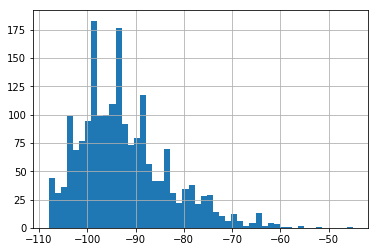

In [9]:
db=db_final[['id','rxLev']]
print "Distribution of RxLev"
db['rxLev'].hist(bins=50)

#### 3.1 First: look at the nb of observations by id

Stats desc of number of observations:

count    320.000000
mean       5.587500
std        7.571923
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       45.000000
dtype: float64 



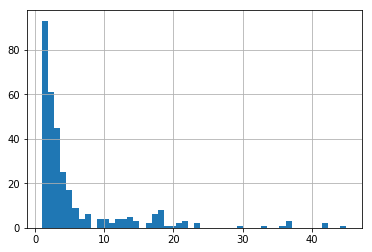

In [10]:
#Distribution of nb observations of rxlevel by id
print "Stats desc of number of observations:\n\n%s \n" %str(db.groupby(u'id').size().describe())
db.groupby('id').size().hist(bins=50)

In [5]:
db.groupby('id').size().hist(range= (0,30),bins=50)

AttributeError: 'dict' object has no attribute 'groupby'

#### 3.2 Now look at the rxlevel/rxlevel max distribution

In [6]:
#Keep inly those with at least 2 observations of rxlevzl
db2_obs=db
db2_obs["nb"]=db2_obs['id'].groupby(db2_obs['id']).transform('value_counts')
db2_obs=db2_obs[db2_obs["nb"]>1]

#Plot histograms of standard deviations of rxlevel by id
db2_obs['rxLev'].groupby(db2_obs['id']).std().hist(bins=50)

KeyError: 'id'

In [7]:
#Look at max distance from the max the pourcentage of change compared to max Rxlev (one per observation here)
db2_obs['max']=db2_obs['rxLev'].groupby(db2_obs['id']).transform('max')
db2_obs['rxLev_norm']=db2_obs['max']/db2_obs['rxLev']

print db2_obs['rxLev_norm'].groupby(db2_obs['id']).min().describe(),"\n"
db2_obs['rxLev_norm'].groupby(db2_obs['id']).min().hist(bins=50)
db2_obs['rxLev_norm'].groupby(db2_obs['id']).min().hist(range=(1,1.5),bins=50)

db2_obs['min_max']=db2_obs['rxLev_norm'].groupby(db2_obs['id']).transform("min")
print db2_obs[db2_obs['min_max']==1],"\n"
#print db2_obs.sort_values('min_max')[:10]


KeyError: 'rxLev'

#### 3.3 Distance versus Rxlevel ratio

In [1]:
#Distance versus ratio of Rxlevel
dist=db_final[['id','rxLev','latabs','lngabs']]
dist['lngabs']=-dist['lngabs']
dist["nb"]=db_final['id'].groupby(db_final['id']).transform('value_counts')
dist=dist[dist["nb"]>1]
print len(dist)

#Get coordinates of the max
dist['max']=dist['rxLev'].groupby(dist['id']).transform('max')
coord_max=dist[dist['rxLev']==dist['max']]
print len(coord_max)

coord_max['dup']=coord_max.duplicated('id')
coord_max['dup']=coord_max['dup'].groupby(dist['id']).transform('max')
#print coord_max[coord_max['dup']==1]

#drop duplicates just in case
coord_max=coord_max.drop_duplicates('id')
coord_max=coord_max.drop(['nb',"max","dup"], axis=1)
coord_max.columns=["id","rxlev_max",'latabs_max',"lngabs_max"]
#print  coord_max

#Merge back and drop max
dist=dist.merge(coord_max,on='id')
dist=dist[dist["rxLev"]!=dist["rxlev_max"]]
dist=dist.drop(["max"],axis=1)
#print dist

#Generate dist to max position
def dist_comp(row):
    return geopy.distance.vincenty((row["latabs"],row["lngabs"]), (row["latabs_max"],row["lngabs_max"])).km

def dist_comp_2(row):
    dx = 71.5 * (row["lngabs"] - row["lngabs_max"])
    dy = 111.3 * (row["latabs"] - row["latabs_max"])
    return math.sqrt(dx*dx+dy*dy)

dist["dist"]=dist.apply(dist_comp, axis=1) 
dist["dist2"]=dist.apply(dist_comp_2, axis=1) 
dist["rx_ratio"]=dist['rxlev_max']/dist["rxLev"]
#print dist

NameError: name 'db_final' is not defined

In [2]:
#Plot plot plot
print "Distance stats desc before cleaning \n\n", dist["dist2"].describe(), "\n"
dist=dist[dist["dist2"]<5]
factor = pd.qcut(dist.dist2, 10)
print "Distance stats desc after cleaning \n\n", dist["dist2"].describe(), "\n"
print "Rxlevel_max/rxlevel stats des \n\n", dist["rx_ratio"].describe(), "\n"

#print dist["dist2"].hist()
#plt.show()

print dist["rx_ratio"].groupby(factor).value_counts().describe(), "\n"

print "level_max/level as a function of distance to where max was captured"
dist["rx_ratio"].groupby(factor).mean().plot()


Distance stats desc before cleaning 



NameError: name 'dist' is not defined

## Notes

##### Distance computation with GPS. Particularly interesting is the pythagoras approximation for fast matrix computation

https://www.movable-type.co.uk/scripts/latlong.html

# BROUIIIIIIIIIIIIIIIIIIIIIIIILLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLONNN

In [226]:
print db[u'id'].value_counts()>1

diamonds.hist(column="carat",        # Column to plot
              figsize=(8,8),         # Plot size
              color="blue")          # Plot color

db=db[db[u'id'].duplicated()==True]

id
1.640465e+09     4
1.220602e+10    20
2.720602e+10     2
3.120602e+10     1
3.120602e+10     4
3.320602e+10     2
3.520602e+10     3
3.520602e+10     1
3.520602e+10    13
3.620602e+10     2
3.820602e+10    11
4.020602e+10     1
4.106001e+10     3
4.120602e+10     3
4.220602e+10     1
4.920602e+10     2
5.020602e+10     1
6.120602e+10     1
7.106001e+10     8
8.202842e+10     1
8.202842e+10    13
9.202842e+10    36
9.202842e+10     9
9.204132e+10     2
9.204202e+10    11
9.204205e+10    14
1.001640e+11     1
1.016404e+11     3
1.020413e+11    16
1.020420e+11     1
                ..
3.010305e+13    10
3.201103e+13     1
3.410305e+13     2
3.410305e+13    13
3.610305e+13     2
3.710305e+13     2
3.710494e+13     9
3.910305e+13    14
4.001103e+13     3
4.210305e+13     5
4.210494e+13     1
4.301103e+13    41
4.510494e+13    10
4.710494e+13     4
4.910305e+13     1
4.910494e+13     2
5.001103e+13    15
5.110305e+13     1
5.501103e+13    32
5.510494e+13     2
5.601103e+13     1
5.610305e

NameError: name 'diamonds' is not defined

In [ ]:
#Try to look at the distribution of the ratio of rxlev/max(rxlevel) for each antennas. Will tell us whether or not there is some variations per antenna

In [223]:
db=db_final[[u'id',u'rxLev']]
#print db.groupby(u'id').size()
print db[u'id'].value_counts()>1
db=db[db[u'id'].duplicated()==True]


8.011030e+12     True
4.301103e+13     True
4.520284e+11     True
5.610305e+13     True
4.106001e+11     True
9.202842e+10     True
6.020413e+11     True
5.501103e+13     True
4.620284e+11     True
2.520413e+11     True
3.510600e+12     True
1.110600e+12     True
4.020420e+11     True
3.320420e+11     True
1.120413e+11     True
1.220602e+10     True
3.320413e+11     True
5.901103e+12     True
4.320284e+11     True
3.620413e+11     True
1.601103e+13     True
2.620413e+11     True
3.101103e+12     True
2.810305e+13     True
1.420420e+11     True
6.110305e+13     True
5.810494e+13     True
2.720420e+11     True
1.210600e+12     True
1.020413e+11     True
                ...  
4.901640e+12    False
4.620420e+11    False
2.201640e+12    False
8.016403e+11    False
3.601640e+12    False
6.016404e+10    False
9.106001e+11    False
1.710600e+12    False
5.101103e+13    False
3.210305e+13    False
5.720420e+11    False
3.016404e+11    False
2.701640e+12    False
2.110600e+12    False
3.801103e+

In [ ]:
BROUILLLLLLLLLLLLLLLLLLLLLLLLOOOONNNNNNNNNNNN

In [62]:
    #nutrients.append(fnuts)1
    #nutrients = pd.concat(nutrients, ignore_index=True)

#test=pd.concat([pd.DataFrame([i], columns=['A']) for i in range(5)],
#ignore_index=True)

test=pd.DataFrame(db['5516640329554'])
test
print test.shape
test2=pd.DataFrame(db['5516640329554'], columns=['rxLev'])
test2

(4, 28)


,rxLev
0,-87
1,-107
2,-103
3,-77


In [33]:
#Explo
print "Nb of unique BS: %i" %len(db)


Nb of unique BS: 442


In [34]:
for i,j in db.items():
    print i,j,'\n'

5516640329554 [{u'rac': u' 1 ', u'pcMeasCh': u' 1 \n', u'rxLev': u' -87 ', u'pbcch': u' 0 ', u'array': u' 1 3 4 5 6 8 9 10 12 13 14 15 513 517 604 605 607 608 609 ', u'mnc': u' 01 ', u'id': u'5516640329554', u'latabs': 47.26260333333333, u'pat': u' 6 ', u'cellId': u' 29554 ', u'spgc': u' 0 ', u'oth_arfcn': u' 519 520 521 522 523 524 525 526 596 597 598 599 600 601 602 603 ', u'drxmax': u' 2 ', u'arfcn': u' 516 ', u'nom': u' 2 ', u'mcc': u' 208 ', u'lac': u' 6403 ', u'cellStatus': u' CELL_FORBIDDEN ', u'numChannels': u' 19 ', u'nco': u' 0 t3168', u'alpha': u' 5 ', u'ctrlAck': u' 0 ', u'gp_time': u'200508.000', u'lngabs': 1.58263, u'numArfcn': u' 16 ', u'bsic': u' 5 ', u'ber': u' 0.00 ', u'bsCVmax': u' 9 '}, {u'rac': u' 1 ', u'pcMeasCh': u' 1 \n', u'rxLev': u' -107 ', u'pbcch': u' 0 ', u'array': u' 1 3 4 5 6 8 9 10 12 13 14 15 513 517 604 605 607 608 609 ', u'mnc': u' 01 ', u'id': u'5516640329554', u'latabs': 47.318295000000006, u'pat': u' 6 ', u'cellId': u' 29554 ', u'spgc': u' 0 ', u'o

In [ ]:
######Pour Laure: preparation des data

In [296]:
#print db_final[['cellid','latabs','lngabs']].groupby(db_final['cellid']).transform('mean')
db_final.shape
#db_final
db_final[['latabs','lngabs']]=db_final[['latabs','lngabs']].groupby(db_final['cellid']).transform('mean')
#print db_final[['latabs','lngabs']]
print db_final[['latabs']].nunique()
db_final=db_final.drop_duplicates(subset='cellid')
print db_final.to_dict(orient='records')
print db_final.shape

latabs    387
dtype: int64
[{'index': 3, u'latabs': 48.11445655115495, u'bsic': 62, u'lngabs': -1.6570456765676622, u'surv_time': u'2018/01/20,10:17:56', 'nb': 101, u'mcc': 208, u'neigh': {u'11': 599, u'10': 598, u'13': 601, u'12': 600, u'15': 603, u'14': 602, u'1': 520, u'0': 519, u'3': 522, u'2': 521, u'5': 524, u'4': 523, u'7': 526, u'6': 525, u'9': 597, u'8': 596}, u'lac': 10301, 'date': Timestamp('2018-01-20 10:17:56'), u'rxlev': -74, u'cellStatus': nan, u'mnc': 1, u'cellid': 48037, u'arfcn': 512}, {'index': 6, u'latabs': 48.114444250502864, u'bsic': 3, u'lngabs': -1.6570383920188585, u'surv_time': u'2018/01/20,10:17:56', 'nb': 994, u'mcc': 208, u'neigh': {u'1': 88, u'0': 77, u'2': 122}, u'lac': 49415, 'date': Timestamp('2018-01-20 10:17:56'), u'rxlev': -80, u'cellStatus': nan, u'mnc': 10, u'cellid': 33517, u'arfcn': 122}, {'index': 7, u'latabs': 48.11445694194128, u'bsic': 57, u'lngabs': -1.6570662612612588, u'surv_time': u'2018/01/20,10:17:56', 'nb': 333, u'mcc': 208, u'neigh': 